# Import Data
## import and install important libraries

In [2]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import re
import json
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [3]:
'''!pip uninstall nltk
!pip install nltk==3.2.5
import nltk'''

'!pip uninstall nltk\n!pip install nltk==3.2.5\nimport nltk'

In [4]:
import emoji#checking if a character is an emoji
import re
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize 
from nltk.corpus import stopwords 
from nltk import sent_tokenize, word_tokenize
import time

In [5]:
'''folder=f'/Users/livi/Documents/2020 Fall/data mining/Proposal/Final Paper/Tweets_Half_Cleaned/'
FinFolder=os.listdir(folder)
Frame=[]
for file in FinFolder[:]:
    if (file.endswith('.csv')) & (file!='.DS_Store'):
        One_Frame=pd.read_csv(join(folder,file),lineterminator='\n',index_col=0)
        Frame.append(One_Frame)
T=pd.concat(Frame)
T.reset_index(inplace=True,drop=True)'''

"folder=f'/Users/livi/Documents/2020 Fall/data mining/Proposal/Final Paper/Tweets_Half_Cleaned/'\nFinFolder=os.listdir(folder)\nFrame=[]\nfor file in FinFolder[:]:\n    if (file.endswith('.csv')) & (file!='.DS_Store'):\n        One_Frame=pd.read_csv(join(folder,file),lineterminator='\n',index_col=0)\n        Frame.append(One_Frame)\nT=pd.concat(Frame)\nT.reset_index(inplace=True,drop=True)"

In [6]:
#T=pd.read_csv('/Users/livi/Git/Tweepy-data-mining/T12292020.csv', index_col=0,lineterminator='\n')

In [7]:
T=pd.read_csv('/Users/livi/Git/Tweepy-data-mining/LIWC2015 Results (T12292020).csv', index_col=0,lineterminator='\n')

In [8]:
#rename columnsT
T_cols=list(T.columns)
T_cols[:18]=['created_at', 'source', 'extended_tweet', 'location', 'CountryCode','SDG', 'id', 'name', 'screen_name', 'url', 'friends_count','followers_count', 'hashtags', 'extended_tweet_lemmatized', 'neg','neu', 'pos', 'compound']
T.columns=T_cols

# LIWC columns
AffectWords=['affect','posemo', 'negemo', 'anx', 'anger', 'sad']
CognetiveProcess=['cogproc','insight', 'cause', 'discrep', 'tentat', 'certain', 'differ']
PerpetualProcesses=['percept','see', 'hear', 'feel']
BiologicalProcesses=['bio', 'body', 'health', 'sexual', 'ingest']
CoreDrivesandNeeds=['drives','affiliation', 'achieve', 'power', 'reward', 'risk']
TimeOrientation=['focuspast', 'focuspresent', 'focusfuture']
Relativity=['relativ','motion', 'space', 'time']
PersonalConcerns=['work', 'leisure', 'home', 'money', 'relig', 'death']
InformalSpeech=['informal','swear','netspeak','assent','nonflu','filler']
PersonalPronouns=['ppron','i','we','you','shehe','they']
SummaryVariable=['Analytic','Clout','Authentic','Tone']
Customized=['neg','pos','compound']

In [9]:
#drop ['location','name','url']
desired_col=['created_at', 'source', 'extended_tweet', 'CountryCode','SDG', 'id', 'screen_name','followers_count', 'hashtags', 'extended_tweet_lemmatized','neu', 'neg','pos', 'compound']
for i in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','PersonalPronouns','SummaryVariable']:
  desired_col.extend(eval(i))
T=T[desired_col]
T.drop(index=T[pd.isnull(T['extended_tweet'])].index,inplace=True)
T.drop(index=T[pd.isnull(T['id'])].index,inplace=True)
T.reset_index(drop=True,inplace=True)

In [10]:
#Country code clean
for i,k in enumerate(T['CountryCode']):
    if ']' in str(k):
        T.loc[i,'CountryCode']='nan'

In [11]:
#str
for col in ['source','extended_tweet','CountryCode','id','extended_tweet_lemmatized']:
    T[col]=T[col].astype(str)
'''#num
for col in ['friends_count','followers_count','neg','neu','pos','compound']:
    T[col]=T[col].astype(float)'''
#apply
for col in ['SDG','hashtags']:
    T[col]=T[col].apply(eval)

In [12]:
T['extended_tweet']=T['extended_tweet'].str.replace('\n',' ')
T['extended_tweet']=T['extended_tweet'].str.replace('#','')

In [13]:
for i in T.columns:
    if T[i].dtypes=='float64':
        T[i].replace(0,np.nan,inplace=True)

In [14]:
for n,i in enumerate(T['SDG']):
    if isinstance(i,float):
        T.drop(index=n,inplace=True)
T.reset_index(drop=True, inplace=True)

In [15]:
T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471242 entries, 0 to 471241
Data columns (total 71 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   created_at                 471242 non-null  object 
 1   source                     471242 non-null  object 
 2   extended_tweet             471242 non-null  object 
 3   CountryCode                471242 non-null  object 
 4   SDG                        471242 non-null  object 
 5   id                         471242 non-null  object 
 6   screen_name                471242 non-null  object 
 7   followers_count            465935 non-null  float64
 8   hashtags                   471242 non-null  object 
 9   extended_tweet_lemmatized  471242 non-null  object 
 10  neu                        471242 non-null  float64
 11  neg                        168691 non-null  float64
 12  pos                        380023 non-null  float64
 13  compound                   40

In [16]:
T['followers_count'].describe()

count    4.659350e+05
mean     1.090074e+04
std      1.574436e+05
min      1.000000e+00
25%      1.610000e+02
50%      7.910000e+02
75%      3.003000e+03
max      1.524228e+07
Name: followers_count, dtype: float64

# Data Cleaning

## Generate user information

### Detect Bot and Consider label Bot
1. interarrival time is smaller than 5 seconds(Tested, mainly small intervals are caused by long tweets)
2. other weird resource (source from bot may have interarrival time much longer 5 sec) Most effective method
3. number of tweets per day (statuses_count, not used here, because there are accounts which frequently tweets)

number of Influencer:A micro-influencer is someone who has between 1,000 to 100,000 followers

In [17]:
#Assign user type
T['UserType']=''
screen_name_of_bots=list(T[T['source'].str.contains('bot')]['screen_name'].unique())
screen_name_of_bots.extend(['trendsinAI','form_bot','UDHROne257_247','globalhealthbot'])
screen_name_of_bots.extend(list(T[T['screen_name'].str.contains('retweet',case=False)]['screen_name'].unique()))
BFF=T[['screen_name','followers_count']].groupby(['screen_name']).agg({'followers_count':'max'}).reset_index()
#assign user
screen_name_of_user=list(BFF[(BFF['followers_count']<=800)]['screen_name'].unique())
T.loc[(T['screen_name'].isin(screen_name_of_user))& (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='user'
#assign influencer
screen_name_of_influencer=list(BFF[(BFF['followers_count']>800)]['screen_name'].unique())
screen_name_of_influencer.extend(list(T[T['screen_name'].str.contains('news',case=False)]['screen_name'].unique()))
T.loc[(T['screen_name'].isin(screen_name_of_influencer)) & (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='influencer'
#assign bots
T.loc[T['screen_name'].isin(screen_name_of_bots),'UserType']='bot'

In [18]:
T=T[T['UserType']=='user'].reset_index(drop=True)

In [19]:
T.shape

(226610, 72)

### include other SDG according to the keywords

In [20]:
'''#choose to include keywords for sdgs or not
def addsdg(df):
    newdf=df.copy(deep=True)
    keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],    ['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]
    for i in range(16):
        for ii in keyword_list[i]:
            for iii in newdf[newdf['hashtags'].apply(lambda x: ii in x)].index:
                newdf.loc[iii,'SDG'].append('SDG'+str(i+1))
            #print(i+1,keyword_list[i],ii)
    
    return newdf'''

"#choose to include keywords for sdgs or not\ndef addsdg(df):\n    newdf=df.copy(deep=True)\n    keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],    ['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]\n    for i in range(16):\n        for ii in keyword_list[i]:\n            for iii in newdf[newdf['hashtags'].apply(lambda x: ii in x)].index:\n                newdf.loc[iii,'SDG'].append('SDG'+str(i+1))\n            #print(i+1,keyword_list[i],ii)\n    \n    return newdf"

###  Generate labels topic

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
'''PopSDGs=['SDG'+str(i) for i in [4,5,7,2,16]]
for PopSDG in PopSDGs:
  searchTerm = PopSDG
  TextExt=T[[searchTerm in x for x in T['SDG']]]
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=5, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(TextExt['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
   for i in top_topic_words:
      print(count_vect.get_feature_names()[i])
  for i,topic in enumerate(LDA.components_):
      print(f'Top 20 words for {PopSDG} topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-20:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  T[PopSDG+'Topic']=None
  #putinto the main matrix
  T.loc[TextExt.index,PopSDG+'Topic']=topic_values.argmax(axis=1)'''

"PopSDGs=['SDG'+str(i) for i in [4,5,7,2,16]]\nfor PopSDG in PopSDGs:\n  searchTerm = PopSDG\n  TextExt=T[[searchTerm in x for x in T['SDG']]]\n  #parameter set-up\n  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')\n  LDA = LatentDirichletAllocation(n_components=5, random_state=42)\n  #topic modeling\n  tweet_matrix=count_vect.fit_transform(TextExt['extended_tweet_lemmatized'].values.astype('U'))\n  LDA.fit(tweet_matrix)\n  #print results\n   for i in top_topic_words:\n      print(count_vect.get_feature_names()[i])\n  for i,topic in enumerate(LDA.components_):\n      print(f'Top 20 words for {PopSDG} topic #{i}:')\n      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-20:]])\n      print('\n')\n  print('*'*50)\n  #put topic back to tweets\n  topic_values = LDA.transform(tweet_matrix)\n  T[PopSDG+'Topic']=None\n  #putinto the main matrix\n  T.loc[TextExt.index,PopSDG+'Topic']=topic_values.argmax(axis=1)"

### Select Countries

In [23]:
selected_country=['United States','United Kingdom','Australia','India','Nigeria']


In [24]:
#### Developing and Developed Country Compare (vote the top then select)
#define developed country and developing country
developed_country='Canada,United States,Australia,Japan,New Zealand,Austria,Belgium,Denmark,Finland,France,Germany,Greece,Ireland,Italy,Luxembourg,Netherlands,Portugal,Spain,Sweden,United Kingdom,Bulgaria,Croatia,Cyprus,Czechia,Estonia,Hungary,Latvia,Lithuania,Malta,Poland,Romania,Slovakia,Slovenia,Iceland,Norway,Switzerland'.split(',')
transition='Albania,Bosnia and Herzegovina,Montenegro,North Macedonia,Serbia,Armenia,Azerbaijan,Belarus,Georgia,Kazakhstan,Kyrgyzstan,Moldova,Russia,Tajikistan,Turkmenistan,Ukraine,Uzbekistan'.split(',')
developing_country='Algeria,Egypt,Libya,Mauritania,Morocco,Sudan,Tunisia,Cameroon,Central African Republic,Chad,Republic of the Congo,Equatorial Guinea,Gabon,São Tomé and Príncipe,Burundi,Comoros,Democratic Republic of the Congo,Djibouti,Eritrea,Ethiopia,Kenya,Madagascar,Rwanda,Somalia,South Sudan,Uganda,Tanzania,Angola,Botswana,Eswatini,Lesotho,Malawi,Mauritius,Mozambique,Namibia,South Africa,Zambia,Zimbabwe,Benin,Burkina Faso,Cape Verde,Côte d\'Ivoire,The Gambia,Ghana,Guinea,Guinea-Bissau,Liberia,Mali,Niger,Nigeria,Senegal,Sierra Leone,Togo,Brunei,Cambodia,China,North Korea,Fiji,Hong Kong,Indonesia,Kiribati,Laos,Malaysia,Mongolia,Myanmar (Burma),Papua New Guinea,Philippines,South Korea,Samoa,Singapore,Solomon Islands,Taiwan,Thailand,Timor-Leste,Vanuatu,Vietnam,Afghanistan,Bangladesh,Bhutan,India,Iran,Maldives,Nepal,Pakistan,Sri Lanka,Bahrain,Iraq,Israel,Jordan,Kuwait,Lebanon,Oman,Qatar,Saudi Arabia,Palestine,Syria,Turkey,United Arab Emirates,Yemen,The Bahamas,Barbados,Belize,Guyana,Jamaica,Suriname,Trinidad and Tobago,Costa Rica,Cuba,Dominican Republic,El Salvador,Guatemala,Haiti,Honduras,Mexico,Nicaragua,Panama,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Paraguay,Peru,Uruguay,Venezuela'.split(',')



# Analysis

In [25]:
Users=T[['screen_name','id','UserType','source']].groupby('screen_name').agg({'id':'count','UserType':'last','source':'last'})

In [26]:
Users.sort_values('id',ascending=False,inplace=True)
Users.reset_index(inplace=True)

In [27]:
cri_bot=Users['UserType']=='bot'
cri_user=Users['UserType']=='user'
cri_influencer=Users['UserType']=='influencer'

In [28]:
set(Users['screen_name'].to_list()[:30]).intersection(set(Users[cri_user]['screen_name'].to_list()[:15]))

{'AbaddeConsult',
 'AfterEffectsAE',
 'BHASolutions',
 'Climate_4_All',
 'EcologyAfricaF1',
 'GerriMonique',
 'Global1Event',
 'GrapesIsFood',
 'InfosecMayer',
 'PatentMasks',
 'UCRGalle',
 'dennyfornyc',
 'hiddenhungerpk',
 'tim39941098',
 'vasana_fai'}

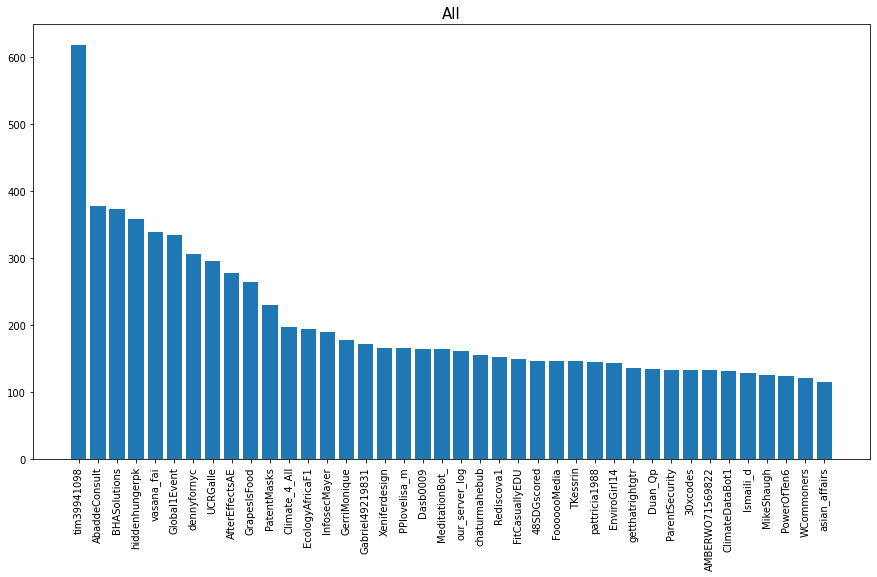

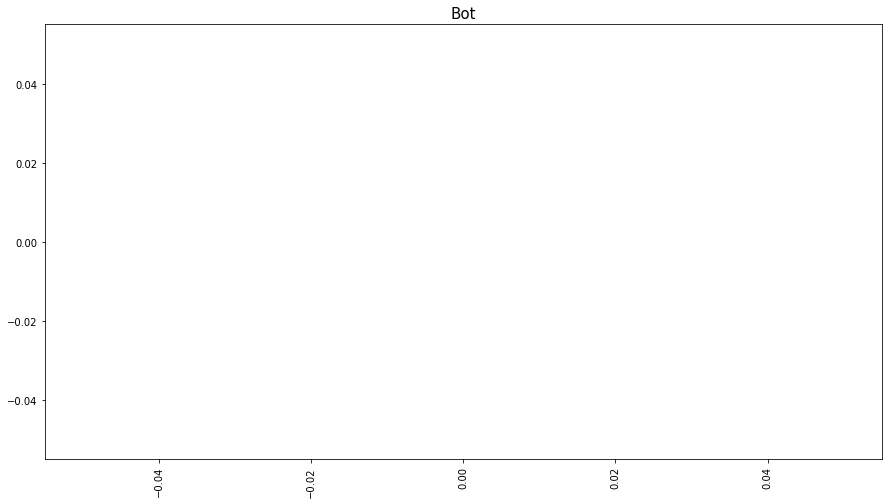

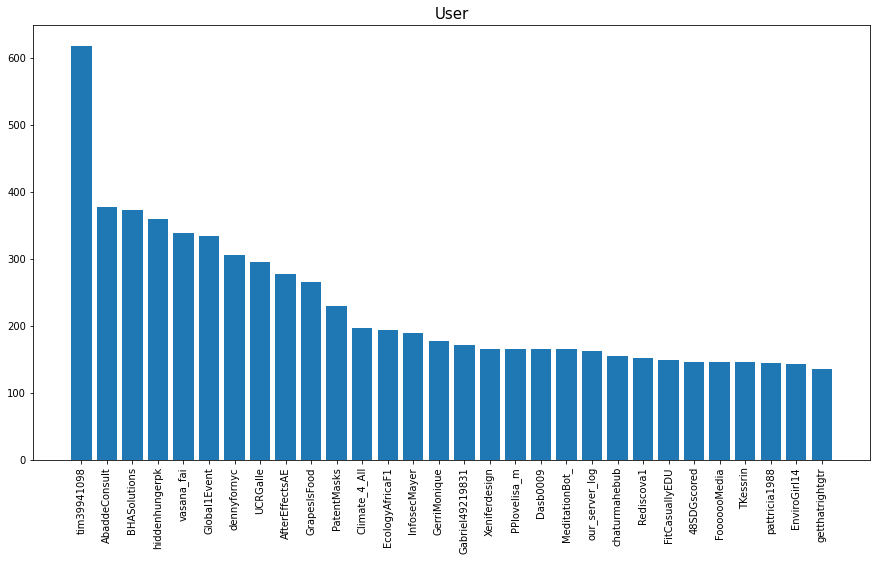

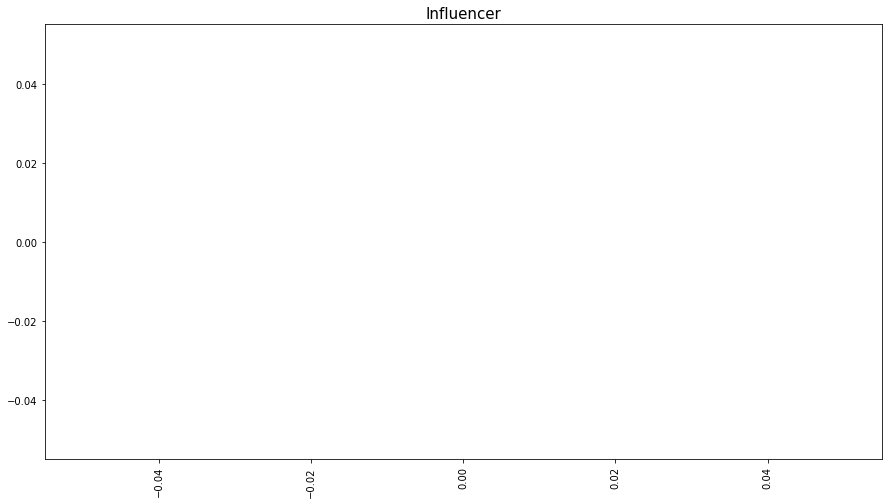

In [29]:
plt.figure(figsize=(15,8))
plt.bar(Users['screen_name'].to_list()[:40],Users['id'].to_list()[:40])
plt.title('All', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_bot]['screen_name'].to_list()[:15],Users[cri_bot]['id'].to_list()[:15])
plt.title('Bot', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_user]['screen_name'].to_list()[:30],Users[cri_user]['id'].to_list()[:30])
plt.title('User', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_influencer]['screen_name'].to_list()[:15],Users[cri_influencer]['id'].to_list()[:15])
plt.title('Influencer', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [30]:
T[['screen_name','id','UserType','source']].groupby('UserType').agg({'id':'count','source':'last','screen_name':'last'})

,id,source,screen_name
UserType,,,
user,226610,hootsuite inc.,SkyJuiceInc


## Frequency of SDG

In [31]:
TT=T[['extended_tweet', 'SDG','CountryCode']]

In [32]:
TT['length']=TT['SDG'].apply(lambda x: type(x))

In [33]:
'''for n,i in enumerate(TT['SDG']):
    if isinstance(i,float):
        TT.drop(index=n,inplace=True)
        T.drop(index=n,inplace=True)
TT.reset_index(drop=True, inplace=True)
T.reset_index(drop=True, inplace=True)'''

"for n,i in enumerate(TT['SDG']):\n    if isinstance(i,float):\n        TT.drop(index=n,inplace=True)\n        T.drop(index=n,inplace=True)\nTT.reset_index(drop=True, inplace=True)\nT.reset_index(drop=True, inplace=True)"

In [34]:
TT['length']=TT['SDG'].apply(lambda x: len(x))

In [35]:
TT=TT[[len(i)>0 for i in TT['SDG']]]
TT.reset_index(drop=True,inplace=True)
print(TT.shape)
TT.head()

(26602, 4)


,extended_tweet,SDG,CountryCode,length
0,what is the nutritional composition of the mos...,[SDG2],United States,1
1,super interesting discussion at ghtc2020 energ...,[SDG7],United Kingdom,1
2,the wiid (world income inequality database) ha...,[SDG10],Finland,1
3,ofgem has issued three suppliers with final or...,[SDG7],United States,1
4,learn more about @asuglobalfuture's sdg5 gende...,[SDG5],United States,1


In [36]:
#Clean up the string
Tdict={}
for i in TT['SDG'].to_list():
    for ii in i:
        if ii in Tdict:
            Tdict[ii]+=1
        else:
            Tdict[ii]=1
#Tdict['']+=Tdict['']
try:
  Tdict['SDG1']+=Tdict['SDG01']
  Tdict['SDG8']+=Tdict['SDG08']
  Tdict['SDG6']+=Tdict['SDG64']
  Tdict['SDG4']+=Tdict['SDG04']
  del Tdict['SDG01']
  del Tdict['SDG04']
  #del Tdict['SDG4ALL']
  #del Tdict['SDG4B']
  #del Tdict['SDG4IT']
  #del Tdict['SDG4SURVEY']
  #del Tdict['SDG4PT7']
  del Tdict['SDG64']
  del Tdict['SDG08']
  del Tdict['SDG18']
  del Tdict['SDG200']
  del Tdict['SDG2030']
  del Tdict['SDG2020']
  del Tdict['SDG19']

except:
  #raise
  pass
Tdict={k:v for k,v in sorted(Tdict.items(), key=lambda x: x[1],reverse=True)}
sorted(Tdict)

['SDG1',
 'SDG10',
 'SDG11',
 'SDG12',
 'SDG13',
 'SDG14',
 'SDG15',
 'SDG16',
 'SDG17',
 'SDG2',
 'SDG3',
 'SDG4',
 'SDG5',
 'SDG6',
 'SDG7',
 'SDG8',
 'SDG9']

dict_keys(['SDG4', 'SDG2', 'SDG5', 'SDG7', 'SDG3', 'SDG13', 'SDG16', 'SDG12', 'SDG6', 'SDG14', 'SDG11', 'SDG17', 'SDG1', 'SDG10', 'SDG8', 'SDG15', 'SDG9'])


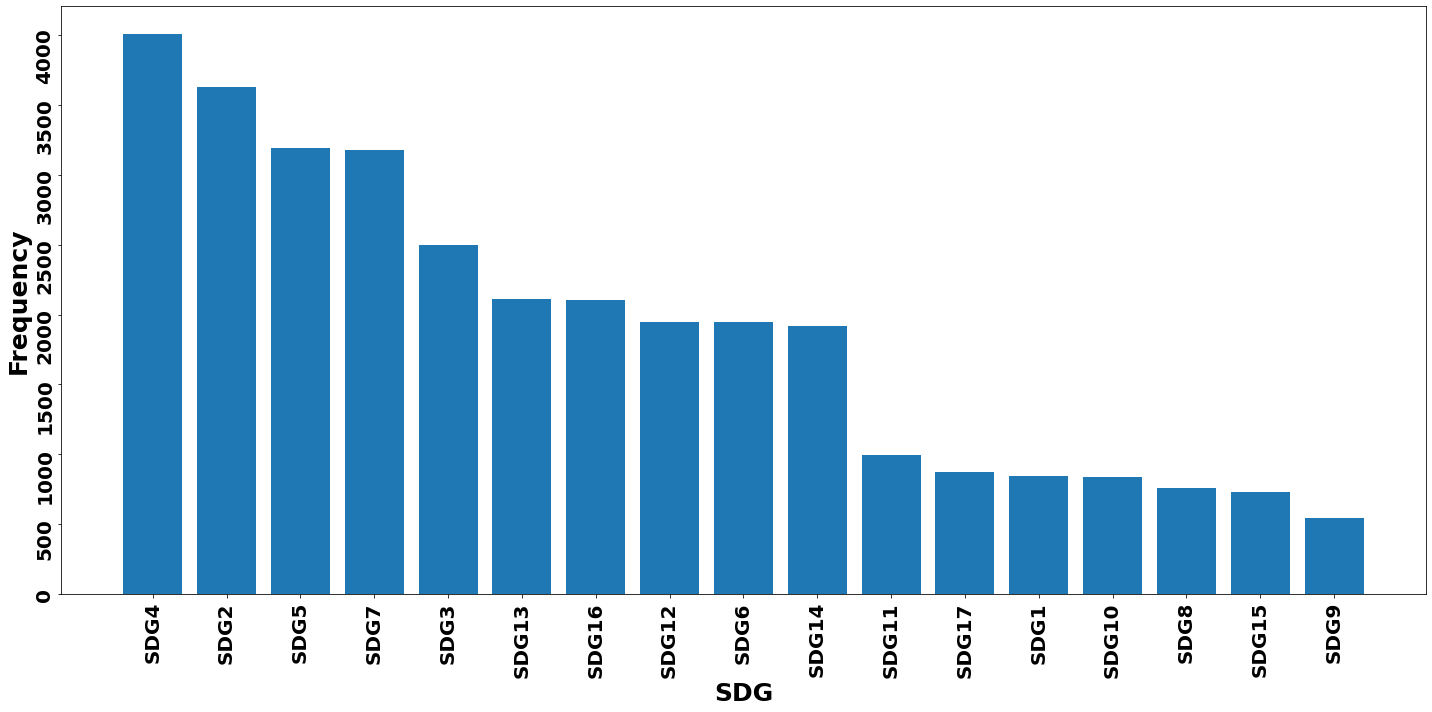

In [37]:
print(Tdict.keys())
plt.figure(figsize=(20,10))
plt.bar(Tdict.keys(),Tdict.values())
plt.xlabel('SDG',fontsize=25,weight='bold')
plt.xticks(fontsize=20,weight='bold',rotation=90)
plt.yticks(fontsize=20,weight='bold',rotation=90)
plt.ylabel('Frequency',fontsize=25,weight='bold')
plt.tight_layout()
#plt.savefig('SDG popularity.jpg',dpi=300)
plt.show()

## Generate National Graph
### import libraty and geojson

In [38]:
import folium

In [39]:
with open('/Users/livi/Git/Tweepy-data-mining/countries.geojson') as f:
  geodata = json.load(f)

In [40]:
holdlist=[]
allcountries=[]
for k,i in enumerate(geodata['features']):
  allcountries.append(i['properties']['ADMIN'])
  if i['properties']['ADMIN'] in T['CountryCode'].tolist():
    holdlist.append(i['properties']['ADMIN'])

In [41]:
print('Overlap of geojson and countrycode:',len(np.unique(np.array(holdlist))))
print('CountryCode in data:',len(T['CountryCode'].unique()))
print('Geojson we have:',len(np.unique(allcountries)))
df1=pd.DataFrame(allcountries)
df1.index=df1[0]
df1.columns=['geojson']
df2=pd.DataFrame(T['CountryCode'].unique())
df2.index=df2[0]
df2.columns=['googlemap']

Overlap of geojson and countrycode: 222
CountryCode in data: 232
Geojson we have: 255


In [42]:
#countries could not be identified
countrynotincluded=list(set(T['CountryCode'].unique())-set(np.unique(np.array(holdlist))))
sum(T['CountryCode'].isin(countrynotincluded)),len(T)

(92292, 226610)

In [43]:
'''contriesLists=pd.concat([df1, df2], axis=1, sort=False,join='outer')
D=contriesLists[contriesLists['googlemap']!=contriesLists['geojson']]'''

"contriesLists=pd.concat([df1, df2], axis=1, sort=False,join='outer')\nD=contriesLists[contriesLists['googlemap']!=contriesLists['geojson']]"

### Plot Frequency Map and sccatter plot

In [44]:
PP=T[['CountryCode', 'id']].groupby('CountryCode').count()
PP.reset_index(inplace=True)
PP.sort_values('id',ascending=False,inplace=True)
PP['count']=np.log10(PP['id'])

In [45]:
#frequency map of tweets
'''m = folium.Map(location=[0, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geodata,
    name='choropleth',
    data=PP,
    columns=['CountryCode', 'count'],
    key_on='feature.properties.ADMIN',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='# of Tweets'
).add_to(m)

folium.LayerControl().add_to(m)
m'''

"m = folium.Map(location=[0, 0], zoom_start=2)\nfolium.Choropleth(\n    geo_data=geodata,\n    name='choropleth',\n    data=PP,\n    columns=['CountryCode', 'count'],\n    key_on='feature.properties.ADMIN',\n    fill_color='YlGn',\n    fill_opacity=0.7,\n    line_opacity=0.2,\n    legend_name='# of Tweets'\n).add_to(m)\n\nfolium.LayerControl().add_to(m)\nm"

In [46]:
#plot of all countries and counts
'''plt.figure(figsize=(20,10))
#plt.bar(PP.CountryCode[:30],PP.text[:30])
plt.scatter(range(len(PP.CountryCode)),PP['count'])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('log_10 Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('1023place dis.jpg')
plt.show()'''

"plt.figure(figsize=(20,10))\n#plt.bar(PP.CountryCode[:30],PP.text[:30])\nplt.scatter(range(len(PP.CountryCode)),PP['count'])\nplt.xlabel('Country',fontsize=20)\nplt.xticks(rotation=90,fontsize=15)\nplt.yticks(fontsize=15)\nplt.ylabel('log_10 Frequency',fontsize=20)\nplt.tight_layout()\n#plt.savefig('1023place dis.jpg')\nplt.show()"

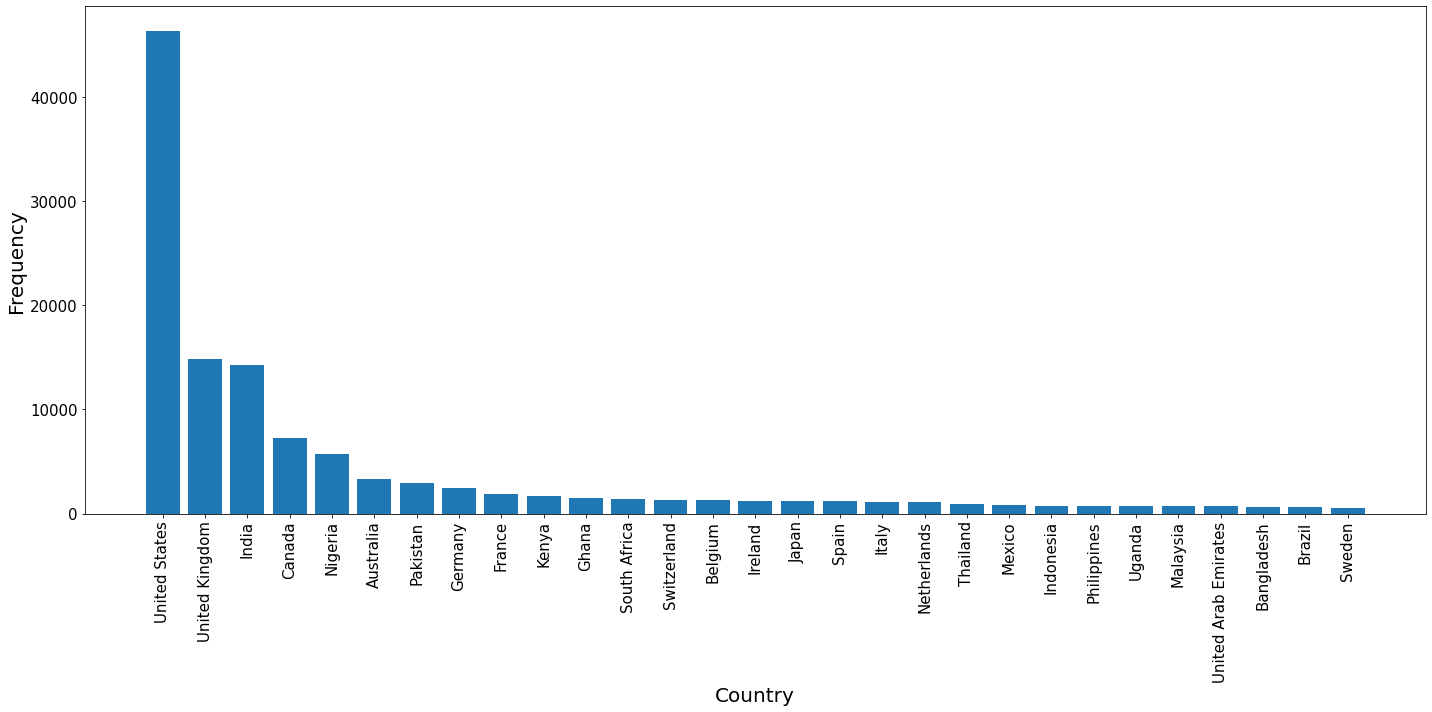

In [47]:
plt.figure(figsize=(20,10))
plt.bar(PP.CountryCode[1:30],PP.id[1:30])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('Tweets Frequency with countries.jpg',dpi=300)
plt.show()

### plot SDG Map and heatmap table 


In [48]:
#Country and SDG distribution
CS=T[['CountryCode','SDG']]
SDs={}
for coun in CS['CountryCode'].unique():
    SDs[coun]={'SDG'+str(i+1):0 for i in range(17)}
    temp=CS[CS['CountryCode']==coun]['SDG']
    for S in temp:
        for SS in S:
            try:
              SDs[coun][SS]+=1
            except:
                pass  

#### Top SDG based on Country

In [49]:
'''top5EnCoun=PP.CountryCode[1:4].tolist()
for topcount in top5EnCoun:
  plt.figure(figsize=(14,7))
  plt.bar(SDs[topcount].keys(),SDs[topcount].values())
  plt.title(topcount,fontsize=25,weight='bold')
  plt.xlabel('SDG',fontsize=25,weight='bold')
  plt.xticks(fontsize=20,weight='bold',rotation=90)
  plt.yticks(fontsize=20,weight='bold',rotation=90)
  plt.ylabel('Frequency',fontsize=25,weight='bold')
  plt.tight_layout()
  #plt.savefig(topcount+'.jpg')'''

"top5EnCoun=PP.CountryCode[1:4].tolist()\nfor topcount in top5EnCoun:\n  plt.figure(figsize=(14,7))\n  plt.bar(SDs[topcount].keys(),SDs[topcount].values())\n  plt.title(topcount,fontsize=25,weight='bold')\n  plt.xlabel('SDG',fontsize=25,weight='bold')\n  plt.xticks(fontsize=20,weight='bold',rotation=90)\n  plt.yticks(fontsize=20,weight='bold',rotation=90)\n  plt.ylabel('Frequency',fontsize=25,weight='bold')\n  plt.tight_layout()\n  #plt.savefig(topcount+'.jpg')"

#### distribution heatmap 

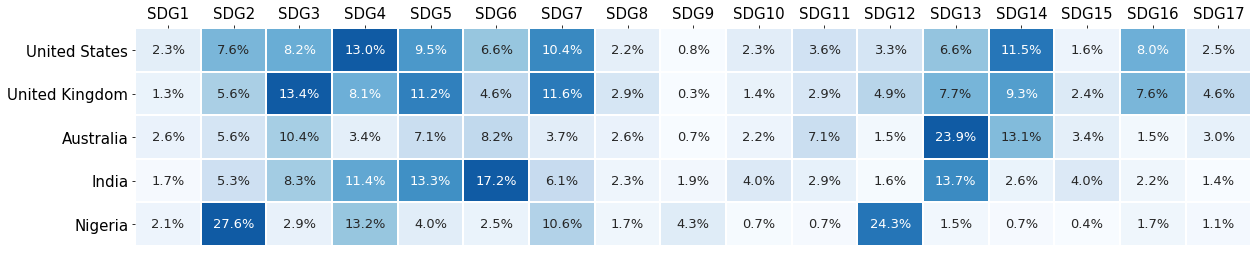

In [55]:
SD_Coun_HM=pd.DataFrame({i:SDs[i] for i in selected_country})
rowname,colname=SD_Coun_HM.columns,SD_Coun_HM.index
#prepare label
HM_label=SD_Coun_HM.div(SD_Coun_HM.sum(axis=0),axis=1).T.values
#prepare data
SD_Coun_HM=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(SD_Coun_HM).T)
SD_Coun_HM.index,SD_Coun_HM.columns=rowname,colname
#plt
plt.figure(figsize=(20,4))
axhm = plt.gca()
axhm.xaxis.set_ticks_position('top')
cmp=sns.color_palette("Blues", as_cmap=True)
sns.heatmap(SD_Coun_HM,cmap=cmp,vmax=1.2,linewidths=1,annot=HM_label,fmt='.1%',cbar=False,annot_kws={"fontsize":13})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('HeatMap Country User.png',dpi=300)
plt.show()

#### SDG change over time

In [ ]:
'''def SDGovertime(T):
    for ii in range(4):
        l=[]
        plt.figure(figsize=(18,5))
        for i in range(ii*5,(ii+1)*5,1):
            searchterm='SDG'+str(i+1)
            Trend=pd.DataFrame()
            Trend['created_at']=T[T['SDG'].apply(lambda x: searchterm in x)]['created_at'].sort_values()
            Trend['count']=1
            Trend['created_at']=pd.to_datetime(Trend['created_at'])
            plt.plot(Trend.groupby(pd.Grouper(key="created_at", freq="1w")).sum())
            plt.xticks(rotation=90)
            l.append(searchterm)
        plt.legend(l,loc=2)
    plt.show()

SDGovertime(T[T['CountryCode']=='United States'])'''

#### Distribution of SDG

In [ ]:
def multi_dict_max(dict):
    max_value=max(dict.values())
    return [i for i in dict.keys() if dict[i]==max_value]
def multi_dict_min(dict):
    min_value=min(dict.values())
    return [i for i in dict.keys() if dict[i]==min_value]

In [ ]:
#Color of each SDG
Colors=['#e4253c','#dea73a','#4c9f45','#c5202e','#f0412b','#29bee2','#fac315','#a21c44','#f26a2c','#dd1768','#f99d27','#be8b2c','#417f45','#1c97d3','#5dbb47','#06699e','#18486b']
SDGcolor={'SDG'+str(i+1):Colors[i] for i in range(17)}

#statistic of some selected countries
#statistic of some selected countries
EsC_count={}
for i in SDs.keys():
    if i==i and i not in ["['SDG14']","[]"]:
        try:
            EsC_count[i]={'sum':0,'top':0,'percentage':0}
            EsC_count[i]['sum']=sum(SDs[i].values())
            if EsC_count[i]['sum']!=0:
                EsC_count[i]['percentage']=round(max(SDs[i].values())/sum(SDs[i].values())*100,1)
            else:
                EsC_count[i]['percentage']=0
            EsC_count[i]['top']=multi_dict_max(SDs[i])
            EsC_count[i]['bottom']=multi_dict_min(SDs[i])
            #EsC_count[i]['geo']=[geodict[i]['lat'],geodict[i]['lng']]
        except:
            raise
#select some countries
ggdataEsC=geodata
select=[]
for i in range(len(ggdataEsC['features'])):
    if ggdataEsC['features'][i]['properties']['ADMIN'] in EsC_count.keys():
        select.append(i)
ggdataEsC['features']=[ggdataEsC['features'][i] for i in select]

In [ ]:
#plot the graph least popular sdg
def stfunc(features):
    sort_features={i:Tdict[i] for i in EsC_count[features['properties']['ADMIN']]['bottom']}
    sort_features=sorted(sort_features.items(),key=lambda x: x[1])
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[sort_features[0][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

o = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(o)
o

In [ ]:
#plot the graph most popular
def stfunc(features):
    sort_features={i:Tdict[i] for i in EsC_count[features['properties']['ADMIN']]['top']}
    sort_features=sorted(sort_features.items(),key=lambda x: x[1],reverse=True)
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[sort_features[0][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

n = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(n)
n

#### vote the top then select, developing and developed countries

In [ ]:
def talkmost(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20 & max(country_SDs[i].values())>1:#make sure more than 1 tweets in the max column
        MAXtop=max(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MAXtop])    
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

def talkleast(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20:#make sure more than 1 tweets in the max column
        MINtop=min(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MINtop])
        #print(MINtop)
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

In [ ]:
plt.figure(figsize=(15,5))
talkmost(developed_country,'Developed talk Most')
plt.figure(figsize=(15,5))
talkleast(developed_country,'Developed talk Least')
plt.figure(figsize=(15,5))
talkmost(developing_country,'developing talk Most')
plt.figure(figsize=(15,5))
talkleast(developing_country,'developing talk Least')
plt.figure(figsize=(15,5))
talkmost(transition,'Transition talk Most')
plt.figure(figsize=(15,5))
talkleast(transition,'Transition talk Least')

#### Based on Frequency

In [ ]:
def toptalkfreq(countrylist,T):
  SD_Co=pd.DataFrame({i:SDs[i] for i in countrylist})
  SD_Co.sum(axis=1).sort_values(ascending=False).plot(kind='bar')
  l=list(SD_Co.sum(axis=1).sort_values(ascending=False).index)
  #l = [i.strip('\'\'') for i in l]
  print(l)

  plt.title(T)
  plt.show()

In [ ]:
plt.figure(figsize=(10,5))
toptalkfreq(developed_country,'Developed Countries')
plt.figure(figsize=(10,5))
toptalkfreq(developing_country,'Developing Countries')

### Print topic for SDG4,SDG2 and SDG5

In [ ]:
 #group support to food security; end food waste; healthy
 for i in [4,2,5]:
     exec('SDG'+str(i)+"=PrintTopic(T[T['SDG'].apply(lambda x: 'SDG'+str(i) in x)],topicnum=3)")

In [ ]:
for i in [4,2,5]:
    sdg_df=eval('SDG'+str(i))
    for ii in range(3):
        print('Topic ',ii, ' of ', 'SDG'+str(i))
        print(*sdg_df[sdg_df['HateTopic']==ii]['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*50+'\n')
        print('\n')
    print('*'*50+'\n')

In [ ]:
print(*T[T['extended_tweet'].str.contains('sdg2 ') & T['extended_tweet'].str.contains('sdg13')]['extended_tweet'].sample(3).tolist(),sep='\n'*3)

In [ ]:
SDG2_HT=[]
for i in T[T['SDG'].apply(lambda x: 'SDG2' in x)]['hashtags']:
    SDG2_HT.extend(i)

In [ ]:
sorted(Counter(SDG2_HT).items(),key=lambda x:x[1],reverse=True)[:30]

## LIWC analysis

#### meaning of columns analysis

In [ ]:
print(len(T['compound']))
print(sum(T['compound']>0)/len(T['compound']),sum(T['compound']<0)/len(T['compound']),sum(T['compound'].isnull())/len(T['compound']))

In [ ]:
import scipy.stats as stats
from itertools import combinations

In [ ]:
'''# LIWC columns
AffectWords=['posemo', 'negemo', 'anx', 'anger', 'sad']
CognetiveProcess=['insight', 'cause', 'discrep', 'tentat', 'certain', 'differ']
PerpetualProcesses=['see', 'hear', 'feel']
BiologicalProcesses=['bio', 'body', 'health', 'sexual', 'ingest']
CoreDrivesandNeeds=['affiliation', 'achieve', 'power', 'reward', 'risk']
TimeOrientation=['focuspast', 'focuspresent', 'focusfuture']
Relativity=['motion', 'space', 'time']
PersonalConcerns=['work', 'leisure', 'home', 'money', 'relig', 'death']
InformalSpeech=['informal','swear','netspeak','assent','nonflu','filler']
PersonalPronouns=['i','we','you','shehe','they']
Customized=['neg','pos','compound']'''

In [ ]:
#hear and see represent the discussion of current situation, feel represent the tendency for a change

In [ ]:
not_selected_direction=['PerpetualProcesses','BiologicalProcesses','CognetiveProcess','InformalSpeech','Relativity','PersonalPronouns']
selected_direction=['AffectWords','Customized','CoreDrivesandNeeds','PersonalConcerns','TimeOrientation']
other=['SummaryVariable','Customized']

#### Study of Selected Country 

In [ ]:
T_COUN=T[T['CountryCode'].isin(selected_country)]

In [ ]:
#all of the data is not normally distributed
'''for LIWCcol in ['PersonalPronouns','AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized','SummaryVariable']:
    for i in eval(LIWCcol):
        for coun in selected_country:
            print(LIWCcol,'shapiro',coun,stats.shapiro(T_COUN[T_COUN['CountryCode']==coun][i]))'''
#Basically everything is normally distributed except summary attributes

#create a stats table
OneFrame=[]
for LIWCcol in selected_direction:
    for i in eval(LIWCcol):
        CounCom=combinations(selected_country,2)
        for couns in CounCom:
            st=stats.ttest_ind(T_COUN[T_COUN['CountryCode']==couns[0]][i].dropna(),T_COUN[T_COUN['CountryCode']==couns[1]][i].dropna(),equal_var=False)
            OneRow=[LIWCcol,i,couns[0],couns[1],st[0],st[1]]
            OneFrame.append(OneRow)
            #print(i,':',couns,stats.ranksums(T_COUN[T_COUN['CountryCode']==couns[0]][i],T_COUN[T_COUN['CountryCode']==couns[1]][i])[1])
stats_table=pd.DataFrame(OneFrame,columns=['keyword1','keyword2','coun1','coun2','test_stats','p-value'])

In [ ]:
#stats_table.to_csv('User stats table based on countries.csv')

In [ ]:
stats_table1=stats_table[stats_table['p-value']<0.05].sort_values('p-value')
stats_table1['coun']=[frozenset([stats_table1.loc[i,'coun1'],stats_table1.loc[i,'coun2']]) for i in stats_table1.index]

stats_table2=stats_table1.groupby('coun').agg({'keyword1':','.join,'keyword2':','.join})
stats_table2['kw1list']=stats_table2['keyword1'].apply(lambda x: set(x.split(',')))
stats_table2['kw2list']=stats_table2['keyword2'].apply(lambda x: set(x.split(',')))

stats_table2['kw1len']=stats_table2['kw1list'].apply(lambda x:len(x))
stats_table2['kw2len']=stats_table2['kw2list'].apply(lambda x:len(x))

In [ ]:
for i in selected_direction:
    display(stats_table1[(stats_table1['coun'].apply(lambda x: 'Nigeria' in x)) & (stats_table1['keyword1']==i)].sort_values('keyword2'))

In [ ]:
#choose to include keywords for sdgs or not
def addsdg(df):
    newdf=df.copy(deep=True)
    keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],    ['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]
    for i in range(16):
        for ii in keyword_list[i]:
            for iii in newdf[newdf['hashtags'].apply(lambda x: ii in x)].index:
                newdf.loc[iii,'SDG'].append('SDG'+str(i+1))
            #print(i+1,keyword_list[i],ii)
    return newdf

In [ ]:
def ranksdg(df, add=False):
    newdf=df
    df_SDG=[]
    for i in newdf['SDG'].to_list():
        df_SDG.extend(i)
    if add==True:
        keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],    ['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]
        for i in range(16):
            for ii in keyword_list[i]:
                for iii in newdf[newdf['hashtags'].apply(lambda x: ii in x)].index:
                    df_SDG.append('SDG'+str(i+1))
    print(sorted(Counter(df_SDG).items(),key=lambda x:x[1], reverse=True))

In [ ]:
#analysis of country
T_happy_Indian=T[(T['CountryCode']=='India') & (T['compound'] >0.9)]
T_sad_Australia=T[(T['CountryCode']=='Australia') & (T['compound'] <-0.5)]

In [ ]:
T_Nigeria=T[(T['CountryCode']=='Nigeria')]

In [ ]:
T_US=T[(T['CountryCode']=='United States')]

In [ ]:
print(*T_US[T_US['you']>10]['extended_tweet'].sample(3).tolist(),sep='\n'*3)

In [ ]:
#print(*T_sad_Australia[T_sad_Australia['extended_tweet'].str.contains('sdg13')]['extended_tweet'].drop_duplicates().sample(5).tolist(),sep='\n'*3)
'''ranksdg(T_happy_Indian,add=True)
print('\n')
ranksdg(T_sad_Australia,add=True)'''

In [ ]:
for LIWCcol in selected_direction:
    colneeded=['CountryCode','id']
    colneeded.extend(eval(LIWCcol))
    aggdict={i:['mean','count'] for i in eval(LIWCcol)}
    aggdict['id']='count'
    DS=T_COUN[colneeded].groupby('CountryCode').agg(aggdict)
    display(DS)
    #DS.to_csv(LIWCcol+'median User.csv')

In [ ]:
for LIWCcol in selected_direction:
    colneeded=[]
    colneeded.extend(eval(LIWCcol))
    for col in colneeded:
        plt.figure(figsize=(10,10))
        for cou in selected_country:
            plt.hist(np.log(T_COUN[T_COUN['CountryCode']==cou][col]),alpha=0.7,bins=100)
        plt.xlim(xmin=0, xmax = 5)
        plt.legend(selected_country)
        plt.title(col)
        plt.show()
    #DS.to_csv(LIWCcol+'median User money.csv') 
for LIWCcol in other:
    colneeded=[]
    colneeded.extend(eval(LIWCcol))
    for col in colneeded:
        plt.figure(figsize=(10,10))
        for cou in selected_country:
            plt.hist(T_COUN[T_COUN['CountryCode']==cou][col],alpha=0.7,bins=100)
        plt.legend(selected_country)
        plt.title(col)
        plt.show()

#### LIWC analysis on developed and developing countries


In [ ]:
T_developed_developing=T[(T['CountryCode'].isin(developed_country)) | (T['CountryCode'].isin(developing_country))]

In [ ]:
T_developed_developing['CountryType']=''
T_developed_developing.loc[T['CountryCode'].isin(developed_country),'CountryType']='developed'
T_developed_developing.loc[T['CountryCode'].isin(developing_country),'CountryType']='developing'

In [ ]:
T_UK_sdg=PrintTopic(T[(T['CountryCode']=='Nigeria') & (T_developed_developing['extended_tweet'].str.contains('sdg2'))], topicnum=2)

In [ ]:
print(T_UK_sdg.shape)
for i in range(2):
    print(*T_UK_sdg[T_UK_sdg['HateTopic']==i]['extended_tweet'].drop_duplicates().sample(3).tolist(),sep='\n'*3)
    print('*'*100)

In [ ]:
T_UK_sdg_HT=[]
for i in T_UK_sdg['hashtags']:
    T_UK_sdg_HT.extend(i)
sorted(Counter(T_UK_sdg_HT).items(), key=lambda x: x[1],reverse=True)[:30]

In [ ]:
def Percentage(x):
        return round(len(x.dropna())/len(x),4)*100

In [ ]:
def Mean(x):
    return round(x.mean(),2)

In [ ]:
def GenMeanPercen(df,selected_direction,needcol):
    DS=[]
    for LIWCcol in selected_direction:
        colneeded=[needcol,'id']
        colneeded.extend(eval(LIWCcol))
        if LIWCcol=='AffectWords':
            aggdict={i:[Mean,Percentage] for i in eval(LIWCcol)}
        else:
            aggdict={i:[CusMean] for i in eval(LIWCcol)}
        DS_temp=df[colneeded].groupby(needcol).agg(aggdict)
        DS_ls=[]
        for DS_col in DS_temp.columns:
            #print((LIWCcol,)+DS_col)
            DS_ls.append((LIWCcol,)+DS_col)
        DS_temp.columns=pd.MultiIndex.from_tuples(DS_ls)
        DS.append(DS_temp.T)
    DS_verticle=pd.concat(DS)
    '''DS_verticle['developed']=DS_verticle['developed'].round(2)
    DS_verticle['developing']=DS_verticle['developing'].round(2)
    len_developed=sum(T_developed_developing['CountryType']=='developed')
    len_developing=sum(T_developed_developing['CountryType']=='developing')
    for i in DS_verticle.index:
        if 'count' in i:
            print(round(DS_verticle.loc[i,'developed']/len_developed*100,4),'developed')
            print(round(DS_verticle.loc[i,'developing']/len_developing*100,4),'developing')
            DS_verticle.loc[i,'developing']=round(DS_verticle.loc[i,'developing']/len_developing*100,4)
            DS_verticle.loc[i,'developed']=round(DS_verticle.loc[i,'developed']/len_developed*100,4)'''

    return DS_verticle

In [ ]:
C_combine=GenMeanPercen(T_developed_developing,selected_direction,'CountryType').join(GenMeanPercen(T_COUN,selected_direction,'CountryCode'))
C_combine=C_combine[['developed', 'developing', 'Australia','United Kingdom', 'United States', 'India', 'Nigeria']]

In [ ]:
C_combine.head()

In [ ]:
C_combine.loc[('AffectWords','sad','Mean')]

In [ ]:
#C_combine.to_csv('all analysis developing and developed percentage.csv')

In [ ]:
#all of the data is not normally distributed
'''for LIWCcol in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns','InformalSpeech','Customized','SummaryVariable']:
    for i in eval(LIWCcol):
        for coun in ['developed','developing']:
            print(LIWCcol,'shapiro',coun,stats.shapiro(T_developed_developing[T_developed_developing['CountryType']==coun][i]))'''
#create a stats table
OneFrame=[]
for LIWCcol in selected_direction:
    for i in eval(LIWCcol):
        CounCom=combinations(['developed','developing'],2)
        for couns in CounCom:
            st=stats.ttest_ind(T_developed_developing[T_developed_developing['CountryType']==couns[0]][i].dropna(),T_developed_developing[T_developed_developing['CountryType']==couns[1]][i].dropna(),equal_var=False)
            OneRow=[LIWCcol,i,couns[0],couns[1],st[0],st[1]]
            OneFrame.append(OneRow)
            #print(i,':',couns,stats.ranksums(T_COUN[T_COUN['CountryCode']==couns[0]][i],T_COUN[T_COUN['CountryCode']==couns[1]][i])[1])
stats_table=pd.DataFrame(OneFrame,columns=['keyword1','keyword2','coun1','coun2','test_stats','p-value'])

In [ ]:
stats_table1=stats_table[(stats_table['p-value']<0.01) & (stats_table['p-value']>=0.001)].sort_values('p-value')
stats_table1['coun']=[frozenset([stats_table1.loc[i,'coun1'],stats_table1.loc[i,'coun2']]) for i in stats_table1.index]
stats_table2=stats_table1.groupby('coun').agg({'keyword1':','.join,'keyword2':','.join})
stats_table2['kw1list']=stats_table2['keyword1'].apply(lambda x: set(x.split(',')))
stats_table2['kw2list']=stats_table2['keyword2'].apply(lambda x: set(x.split(',')))

stats_table2['kw1len']=stats_table2['kw1list'].apply(lambda x:len(x))
stats_table2['kw2len']=stats_table2['kw2list'].apply(lambda x:len(x))

In [ ]:
stats_table1.sort_values('keyword1')

In [ ]:
#stats_table.to_csv('User stats table based on money.csv')

○ Affiliation	-- McClelland-like	dimensions	including	reference	to	others

○ Achievement	-- references	to	success	and	failure,	achievement	striving

○ Power	-- references	relevant	to	status,	dominance,	social	hierarchies

○ Reward	focus	-- references	to	rewards,	incentives,	positive	goals,	approach

○ Risk	focus	-- references	to	dangers,	concerns,	things	to	avoid


In [ ]:

##negmo is complain and disapointment. 
#Need for power — driven by prestige, control, status, and influence over others
#Need for achievement — driven by succeeding, accomplishing goals and overcoming challenges
#Need for affiliation — motivated by close relationships with others
#achievement is 
# power: powerful figures, law
print(*T_developed_developing[(T_developed_developing['leisure']>10) & (T_developed_developing['extended_tweet'].str.contains('sdg'))]['extended_tweet'].sample(10).tolist(),sep='\n'*3)

In [ ]:
stats_table1.sort_values('keyword1')

In [ ]:
DS=[]
for LIWCcol in selected_direction:
    colneeded=['CountryCode','CountryType','id']
    colneeded.extend(eval(LIWCcol))
    aggdict={i:['mean','count'] for i in eval(LIWCcol)}
    DS_temp=T_developed_developing[colneeded].groupby('CountryType').agg(aggdict)
    DS_ls=[]
    for DS_col in DS_temp.columns:
        #print((LIWCcol,)+DS_col)
        DS_ls.append((LIWCcol,)+DS_col)
    DS_temp.columns=pd.MultiIndex.from_tuples(DS_ls)
    DS.append(DS_temp.T)
DS_verticle=pd.concat(DS)
DS_verticle['developed']=DS_verticle['developed'].round(2)
DS_verticle['developing']=DS_verticle['developing'].round(2)
len_developed=sum(T_developed_developing['CountryType']=='developed')
len_developing=sum(T_developed_developing['CountryType']=='developing')
for i in DS_verticle.index:
    if 'count' in i:
        print(round(DS_verticle.loc[i,'developed']/len_developed*100,4),'developed')
        print(round(DS_verticle.loc[i,'developing']/len_developing*100,4),'developing')
        DS_verticle.loc[i,'developing']=round(DS_verticle.loc[i,'developing']/len_developing*100,4)
        DS_verticle.loc[i,'developed']=round(DS_verticle.loc[i,'developed']/len_developed*100,4)

In [ ]:
#DS_verticle.to_csv('all analysis developing and developed percentage.csv')

In [ ]:
for LIWCcol in selected_direction:
    colneeded=['CountryCode','CountryType','id']
    colneeded.extend(eval(LIWCcol))
    aggdict={i:['mean','count'] for i in eval(LIWCcol)}
    DS=T_developed_developing[colneeded].groupby('CountryType').agg(aggdict)
    DS_ls=[]
    for DS_col in DS.columns:
        #print((LIWCcol,)+DS_col)
        DS_ls.append((LIWCcol,)+DS_col)
    DS.columns=pd.MultiIndex.from_tuples(DS_ls)
    display(DS)
    #DS.to_csv(LIWCcol+'median User money.csv') 

In [ ]:
for LIWCcol in selected_direction:
    colneeded=[]
    colneeded.extend(eval(LIWCcol))
    for col in colneeded:
        fig, ax1 = plt.subplots(figsize=(10,10))
        ax2 = ax1.twinx()
        ax1.hist(np.log(T_developed_developing[T_developed_developing['CountryType']=='developing'][col]),alpha=0.7,bins=50,label='developing')
        ax2.hist(np.log(T_developed_developing[T_developed_developing['CountryType']=='developed'][col]),fc=(1, 0, 0, 0.95),alpha=0.7,bins=50)
        ax1.legend()
        #ax1.set_ylabel('Y1 data', color='g')
        #ax2.set_ylabel('Y2 data', color='b')
        plt.xlim(xmin=0, xmax = 5)
        plt.title(col)
        plt.show()
    #DS.to_csv(LIWCcol+'median User money.csv') 
for LIWCcol in other:
    colneeded=[]
    colneeded.extend(eval(LIWCcol))
    for col in colneeded:
        fig, ax1 = plt.subplots(figsize=(10,10))
        ax2 = ax1.twinx()
        ax1.hist(T_developed_developing[T_developed_developing['CountryType']=='developing'][col],alpha=0.7,bins=50,label='developing')
        ax2.hist(T_developed_developing[T_developed_developing['CountryType']=='developed'][col],fc=(1, 0, 0, 0.95),alpha=0.7,bins=50)
        ax1.legend()
        #ax1.set_ylabel('Y1 data', color='g')
        #ax2.set_ylabel('Y2 data', color='b')
        plt.title(col)
        plt.show()


### Strong against SDGs

In [ ]:
def PrintTopic(df, topicnum=5,keywds=20):
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=topicnum, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(df['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
  '''  for i in top_topic_words:
      print(count_vect.get_feature_names()[i])'''
  for i,topic in enumerate(LDA.components_):
      print(f'Top {keywds} words for topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-keywds:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  df['HateTopic']=None
  #putinto the main matrix
  df.loc[df.index,'HateTopic']=topic_values.argmax(axis=1)
  return df


In [ ]:
len(T[T['compound']>0.9]),len(T[T['compound']<-0.5])

#### super positive ones

In [ ]:
T_pos9=T[T['compound']>0.9]
T_pos9=PrintTopic(T_pos9,topicnum=3)

In [ ]:
#T_pos9.to_csv('User positive larger 0.9.csv')

In [ ]:
T_pos9=addsdg(T_pos9)

In [ ]:
#has sdg in row
len(T_pos9[T_pos9['SDG'].apply(lambda x:len(x))>0]),len(T_pos9)
#rank
T_pos9_SDG=[]
for i in T_pos9['SDG'].to_list():
    T_pos9_SDG.extend(i)
sorted(Counter(T_pos9_SDG).items(),key=lambda x:x[1], reverse=True)

In [ ]:
T_pos9[T_pos9['SDG'].apply(lambda x:'SDG16' in x)]['extended_tweet'].sample(1).tolist()

In [ ]:
for i in range(5):
    print('Topic',str(i),':\n')
    print(*T_pos9[T_pos9['HateTopic']==i]['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*30+'\n')
    print('\n'+'*'*50+'\n')

#### super negative ones

In [ ]:
print(*T[T['compound']<-0.5]['extended_tweet'].sample(5).tolist(),sep='\n'+'*'*50+'\n')

In [ ]:
T_neg=T[T['compound']<-0.5]
T_neg=PrintTopic(T_neg)

In [ ]:
#T_neg.to_csv('User negative smaller 0.5.csv')

In [ ]:
T_neg=addsdg(T_neg)

In [ ]:
#lenth of rows has sdg
print(len(T_neg[T_neg['SDG'].apply(lambda x:len(x))>0]),len(T_neg))
#rank sdg
T_neg_SDG=[]
for i in T_neg['SDG'].to_list():
    T_neg_SDG.extend(i)
sorted(Counter(T_neg_SDG).items(),key=lambda x:x[1], reverse=True)

In [ ]:
T_neg[T_neg['SDG'].apply(lambda x:'SDG13' in x)]['extended_tweet'].sample(1).tolist()

In [ ]:
for i in range(5):
    print('Topic',str(i),':\n')
    print(*T_neg[T_neg['HateTopic']==i]['extended_tweet'].sample(3).tolist(),sep='\n'+'-'*30+'\n')
    print('\n'+'*'*50+'\n')

#### both pos and neg, but focus on SDG
people feel disappointed or happy about one specific SDGs

In [ ]:
T_extreme=pd.concat([T_neg,T_pos9]).reset_index()

In [ ]:
def HappyorNot_SDG(df):
    b,n=[],[]
    for i in range(1,18,1):
        name='SDG'+str(i)
        b.append(sum(df[df['SDG'].apply(lambda x: name in x)]['compound']>0)/sum(df[df['SDG'].apply(lambda x: name in x)]['compound']<0)
        n.append(name)
    plt.bar(n,b)
    plt.plot(range(1,18,1),np.ones(17)*sum(df['compound']>0)/sum(df['compound']<0),'red')
    plt.xticks(rotation=90)
    plt.show()

#### select manually

In [ ]:
'''StrongAgainst=T[T['extended_tweet'].str.contains('propaganda|nosdgs|hypocrite|stopsdgs|globalism|hypocrisy|plandemic|pcrtestpandemic|thegreatreset|scamdemic|pcrtestpandemic|itsascam|nowef|nonsa|noimf|nocia|stopthegreatreset|noagenda21|noun |nog30',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()'''

In [ ]:
'''StrongAgainst=T[T['extended_tweet'].str.contains('propaganda|nosdgs|hypocrite|stopsdgs|globalism|hypocrisy|itsascam|nowef|noagenda21|nog30',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()'''

In [ ]:
StrongAgainst=T[T['extended_tweet'].str.contains('nosdgs|noagenda21|nog30|agenda2030 propaganda|stop agenda21|lie of sdgs|lie of sustainabledevelopment|fuck agenda21|force agenda2030|sdgs is a lie|climateaction scam|lie of sustainabledevelopment',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()

In [ ]:
#StrongAgainst=StrongAgainst.append(T_neg[T_neg['extended_tweet'].str.contains('agenda21|agenda30')]).drop_duplicates(subset='extended_tweet')

In [ ]:
StrongAgainst['compound'].describe()

In [ ]:
print(*StrongAgainst['extended_tweet'].sample(25).tolist(),sep='\n'+'-'*30+'\n')

In [ ]:
StrongAgainst_HT=[]
for i in StrongAgainst['hashtags'].tolist():
  StrongAgainst_HT.extend(i)
StrongAgainst_HT=Counter(StrongAgainst_HT)
StrongAgainst_HT={i:k for i,k in sorted(StrongAgainst_HT.items(),key=lambda x:x[1],reverse=True)}
#del StrongAgainst_HT['#sdg']


In [ ]:
plt.figure(figsize=(15,8))
plt.bar(list(StrongAgainst_HT.keys())[:30],list(StrongAgainst_HT.values())[:30])
plt.xticks(rotation=90)
plt.show()
list(StrongAgainst_HT.keys())[:30]

In [ ]:
topnum=4
StrongAgainst=PrintTopic(StrongAgainst,topnum,20)

for i in range(topnum):
  print(*StrongAgainst[StrongAgainst['HateTopic']==i].sample(2)['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
  print('*'*100)

plt.hist(StrongAgainst['HateTopic'])
plt.show()

In [ ]:
print(*T[T['extended_tweet'].str.contains('firetrudeau')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'*3)

In [ ]:
#StrongAgainst.to_csv('User StrongAgainst 42.csv')

In [ ]:
HT=[]
for i in StrongAgainst[StrongAgainst['HateTopic']==1]['hashtags'].tolist():
    HT.extend(i)
sorted(Counter(HT).items(),key=lambda x:x[1],reverse=True)

#### Plandemic related

In [ ]:
Plandemic=T[T['extended_tweet'].str.contains('nosdgs|noagenda21|nog30|agenda2030 propaganda|stop agenda21|lie of sdgs|lie of sustainabledevelopment|fuck agenda21|force agenda2030|sdgs is a lie|plandemic|lie of sustainabledevelopment|nogreatreset|nocia|noglobalism|noimf|noworldbank|nowef|vaxaware|nonewnormal|nonsa|novaccine|nomask|nocia|nofbi|noreset|nolockdown|scamdemic|nonwo',case=False)].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()

Plandemic=Plandemic.append(T[(T['extended_tweet'].str.contains('propaganda')) & (T['extended_tweet'].str.contains('agenda'))].drop_duplicates(subset='extended_tweet'))
Plandemic=Plandemic.append(T[(T['extended_tweet'].str.contains('hypoc')) & (T['extended_tweet'].str.contains('agenda'))].drop_duplicates(subset='extended_tweet'))
Plandemic=Plandemic.append(T[(T['extended_tweet'].str.contains('hypoc')) & (T['extended_tweet'].str.contains('sdg'))].drop_duplicates(subset='extended_tweet'))

In [ ]:
Plandemic=Plandemic.drop_duplicates(subset='extended_tweet')
Plandemic['old_tweet']=Plandemic['extended_tweet']

In [ ]:
print(*T[(T['extended_tweet'].str.contains('nonwo')) & (T['extended_tweet'].str.contains(''))]['extended_tweet'].drop_duplicates().tolist(),sep='\n'*3)

In [ ]:
'''plandemic_HT=[]
for i in Plandemic['hashtags'].tolist():
  plandemic_HT.extend(i)
plandemic_HT=Counter(plandemic_HT)
plandemic_HT={i:k for i,k in sorted(plandemic_HT.items(),key=lambda x:x[1],reverse=True)}
plandemic_HT
#del StrongAgainst_HT['#sdg']'''

In [ ]:
for i in Plandemic.index:
    tweet=Plandemic.loc[i,'extended_tweet']
    for ii in Plandemic.loc[i,'hashtags']:
        tweet=tweet.replace(ii[1:],'')
    Plandemic.loc[i,'extended_tweet']=tweet

In [ ]:
l=['scamdemic', 'people', 'refuse', 'plandemic', 'propaganda', 'agenda21', 'covid19', 'lie', 'agenda2030', 'sdgs']
l.reverse()
print(', '.join(l))

In [ ]:
topnum=2
Plandemic=PrintTopic(Plandemic,topnum,10)

for i in range(topnum):
  print(*Plandemic[Plandemic['HateTopic']==i].sample(2)['old_tweet'].tolist(),sep='\n'+'-'*100+'\n')
  print('*'*100)

plt.hist(Plandemic['HateTopic'])
plt.show()

In [ ]:
P_topic_0,P_topic_1=[],[]
for i in Plandemic[Plandemic['HateTopic']==0]['hashtags'].tolist():
    P_topic_0.extend(i)
for i in Plandemic[Plandemic['HateTopic']==1]['hashtags'].tolist():
    P_topic_1.extend(i)

In [ ]:
print(sorted(Counter(P_topic_0).items(),key=lambda x:x[1],reverse=True)[:15])
print('\n'*3)
print(sorted(Counter(P_topic_1).items(),key=lambda x:x[1],reverse=True)[:15])

In [ ]:
Plandemic.info()

#### Network plot

In [ ]:
AgainstHT=[]
for i in StrongAgainst['hashtags'].tolist():
    AgainstHT.extend(i)

In [ ]:
import networkx as nx
GC = nx.Graph()
GC.add_nodes_from(set(AgainstHT))
for hash_list in StrongAgainst.sort_values('created_at')['hashtags']:
    GC.add_edges_from(combinations(hash_list,2))

In [ ]:
from operator import itemgetter
plt.figure(figsize=(20,20))
# find node with largest degree
node_and_degree = GC.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

# Create ego graph of main hub
hub_ego = nx.ego_graph(GC, largest_hub)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=True,font_weight='bold')

# Draw ego as large and red

options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
#plt.savefig('User StrongAgainst Network.png',dpi=300)
plt.show()

In [ ]:
#nx.write_graphml(GC, '42 StrongAgainst Network.graphml')

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
#plt.axes([0.45, 0.45, 0.45, 0.45])
plt.figure(figsize=(10,5))
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc)
plt.axis("off")
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)
plt.show()

#### negative with asdgs

In [ ]:
T[(T['extended_tweet'].str.contains('sdg')) & (T['extended_tweet'].str.contains('ourmoney'))]

In [ ]:
print(*T[(T['extended_tweet'].str.contains('trudeau')) & (T['extended_tweet'].str.contains('scandal'))]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'*'*50+'\n')

#### strong against only contains nosdg and etc hashtags

In [ ]:
Allhash=[]
for k,i in enumerate(StrongAgainst['hashtags']):
    if isinstance(i,float):
        StrongAgainst.drop(k,inplace=True)
        print(k,i)
    else:
        Allhash.extend(i)
import networkx as nx
AllHT = nx.Graph()
AllHT.add_nodes_from(set(Allhash))

for hash_list in StrongAgainst.sort_values('created_at')['hashtags']:
    AllHT.add_edges_from(combinations(hash_list,2))

nx.write_graphml(AllHT, 'StrongAgainst nosdgs only Network.graphml')

In [ ]:
','.join(['SDG4', 'SDG7', 'SDG16', 'SDG3', 'SDG5', 'SDG2', 'SDG13', 'SDG6', 'SDG14', 'SDG10', 'SDG1', 'SDG12', 'SDG17'])